In [2]:
import numpy as np
import os.path
import cv2
import sys
from src.common import *
from scipy.io import loadmat
from sklearn import metrics
import matplotlib.patches as patches
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib
from src.joint_bayesian import *
import keras_vggface
from matplotlib import pyplot
from PIL import Image
from align import AlignDlib
from numpy import expand_dims
from sklearn.decomposition import PCA
from keras_vggface.vggface import VGGFace
from sklearn.metrics import f1_score, accuracy_score
import tensorflow as tf
from tensorflow import keras as keras
from keras.models import Model
from keras.layers import Dense
from keras_vggface.utils import preprocess_input

In [4]:
# create a vggface2 model
model = VGGFace(model='resnet50')

In [5]:
num_classes = 194
for layer in model.layers:
  layer.trainable = False

def new_model(bottom_model, num_classes):

  top_model = bottom_model.output
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = Dense(num_classes, activation='softmax')(top_model)
  return top_model

vgg_face=Model(inputs=model.layers[0].input,outputs=model.layers[-2].output) 
face_model = new_model(vgg_face, num_classes)
vgg_face = Model(inputs = vgg_face.input, outputs = face_model)
vgg_face.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_2[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In [6]:
vgg_face.load_weights('weights/VGG_Equi_Face.h5')
customized_vgg_face=Model(inputs=vgg_face.layers[0].input,outputs=vgg_face.layers[-2].output)
customized_vgg_face.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_2[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In [9]:
def load_image(path):
    img = cv2.imread(path, 1)
    
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/shape_predictor_68_face_landmarks.dat')

def align_image(img):
    return alignment.align(224, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)


class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in sorted(os.listdir(path)):
        for f in sorted(os.listdir(os.path.join(path, i))):
            # Check file extension. Allow only jpg/jpeg/png files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg' or ext == '.png':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')

In [10]:
embedded = np.empty(512)
metadata_curated = []

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    if img is None:
        pass
    else:
        img = img.astype('float32')
        samples = expand_dims(img, axis=0)
        # prepare the face for the model, e.g. center pixels
        samples = preprocess_input(samples, version=2)
        metadata_curated.append(IdentityMetadata(m.base, m.name, m.file))
        embedded = np.vstack([embedded , customized_vgg_face.predict(samples)])
metadata_curated = np.array(metadata_curated)
embed = np.delete(embedded, 0, 0)
data_to_pkl(embed, "ResNet-50_Fine-Tuned_MOT360_fet.pkl")

Saving data to file(ResNet-50_Fine-Tuned_MOT360_fet.pkl). 


True

In [11]:
feature_list = []
for i in embed:
    feature_list.append(i.flatten())
features_array = np.array(feature_list)

In [12]:
pca = PCA(n_components=0.95)
pca.fit(features_array)
pca_embed = pca.transform(embed)

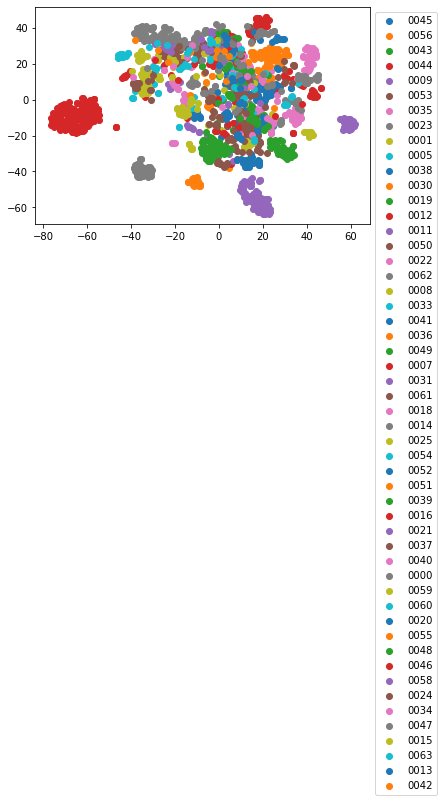

In [13]:
from sklearn.manifold import TSNE

targets = np.array([m.name for m in metadata_curated])
X_embedded = TSNE(n_components=2).fit_transform(pca_embed)

for i, t in enumerate(set(targets)):
    idx = targets == t
    pyplot.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

pyplot.legend(bbox_to_anchor=(1, 1));

In [89]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata_curated])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

with open("data/train_idx_identification.pkl", "rb") as f:
    train_idx = pickle.load(f)
    
with open("data/test_idx_identification.pkl", "rb") as f:
    test_idx = pickle.load(f)

y_train = y[train_idx]
y_test = y[test_idx]

X_train = embed[train_idx]
X_test = embed[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.8922651933701657, SVM accuracy = 0.919889502762431


In [96]:
targets = np.array([m.name for m in metadata_curated])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

with open("data/train_idx_verification.pkl", "rb") as f:
    train_idx = pickle.load(f)
    
with open("data/test_idx_verification.pkl", "rb") as f:
    test_idx = pickle.load(f)
    
y_train = y[train_idx]
y_test = y[test_idx]

X_train = embed[train_idx]
X_test = embed[test_idx]

In [97]:
with open("data/IntraPersonPair.pkl", "rb") as f:
    IntraPersonPair = pickle.load(f)
    
with open("data/ExtraPersonPair.pkl", "rb") as f:
    ExtraPersonPair = pickle.load(f)

print(len(IntraPersonPair))
print(len(ExtraPersonPair))
IntraPersonPair = IntraPersonPair[:6000]
ExtraPersonPair = ExtraPersonPair[:6000]

6000
6000


In [98]:
def excute_train(data, label):

#     # pca training.
    pca = PCA_Train(data, 128)
    data_pca = pca.transform(data)

    JointBayesian_Train(data_pca, label)

In [99]:
excute_train(X_train, y_train)

2020-08-15, 20:15:37  number of components: 128
2020-08-15, 20:15:37  PCA training (n_components=128)...


C:\Users\Abhilash\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Abhilash\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Abhilash\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Abhilash\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Abhilash\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\num

2020-08-15, 20:15:38  PCA done.
(1269, 128)
prepare done, maxNumberInOneClass= 163
2020-08-15, 20:15:38  Iterations-0: 0.0022942229573868636
Saving data to file(./G.pkl). 
Saving data to file(./A.pkl). 
2020-08-15, 20:15:39  Iterations-1: 0.0032117697196409824
2020-08-15, 20:15:40  Iterations-2: 0.0029296587650106134
2020-08-15, 20:15:40  Iterations-3: 0.002605067875655892
2020-08-15, 20:15:41  Iterations-4: 0.0022090973753163875
Saving data to file(./G.pkl). 
Saving data to file(./A.pkl). 
2020-08-15, 20:15:42  Iterations-5: 0.0018100059232749404
Saving data to file(./G.pkl). 
Saving data to file(./A.pkl). 
2020-08-15, 20:15:42  Iterations-6: 0.0016450205401950563
Saving data to file(./G.pkl). 
Saving data to file(./A.pkl). 
2020-08-15, 20:15:43  Iterations-7: 0.0016802865947347294
2020-08-15, 20:15:44  Iterations-8: 0.0017959254912084627
2020-08-15, 20:15:44  Iterations-9: 0.001982918229669612
2020-08-15, 20:15:45  Iterations-10: 0.002125327490073503
2020-08-15, 20:15:46  Iterations-

In [100]:
with open("A.pkl", "rb") as f:
    A = pickle.load(f)
with open("G.pkl", "rb") as f:
    G = pickle.load(f)
clt_pca = joblib.load("pca_model.m")
data = clt_pca.transform(X_test)
data_to_pkl(data, "pca_lfw.pkl")

Saving data to file(pca_lfw.pkl). 


True

In [101]:
dist_Intra = get_ratios(A, G, IntraPersonPair, data)
dist_Extra = get_ratios(A, G, ExtraPersonPair, data)

dist_all = dist_Intra + dist_Extra
dist_all = np.asarray(dist_all)
label    = np.append(np.repeat(1, len(dist_Intra)), np.repeat(0, len(dist_Extra)))

data_to_pkl({"distance": dist_all, "label": label}, "result.pkl")

Saving data to file(result.pkl). 


True

In [102]:
excute_performance("result.pkl", -16.9, -16.6, 0.01)

[1 1 1 ... 0 0 0]
test size:  (12000,)
negative size:  (6000,)
postive size:  (6000,)
threshold:  -16.9
             precision    recall  f1-score   support

      False       0.84      0.90      0.87      6000
       True       0.89      0.83      0.86      6000

avg / total       0.87      0.87      0.87     12000

threshold:  -16.889999999999997
             precision    recall  f1-score   support

      False       0.84      0.90      0.87      6000
       True       0.89      0.83      0.86      6000

avg / total       0.87      0.87      0.87     12000

threshold:  -16.879999999999995
             precision    recall  f1-score   support

      False       0.84      0.90      0.87      6000
       True       0.89      0.83      0.86      6000

avg / total       0.87      0.87      0.87     12000

threshold:  -16.869999999999994
             precision    recall  f1-score   support

      False       0.84      0.90      0.87      6000
       True       0.89      0.83      0.86      